<a href="https://colab.research.google.com/github/Mateo289/Teoria_senales/blob/main/Tarea_15_Nov_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
!pip install spectrum

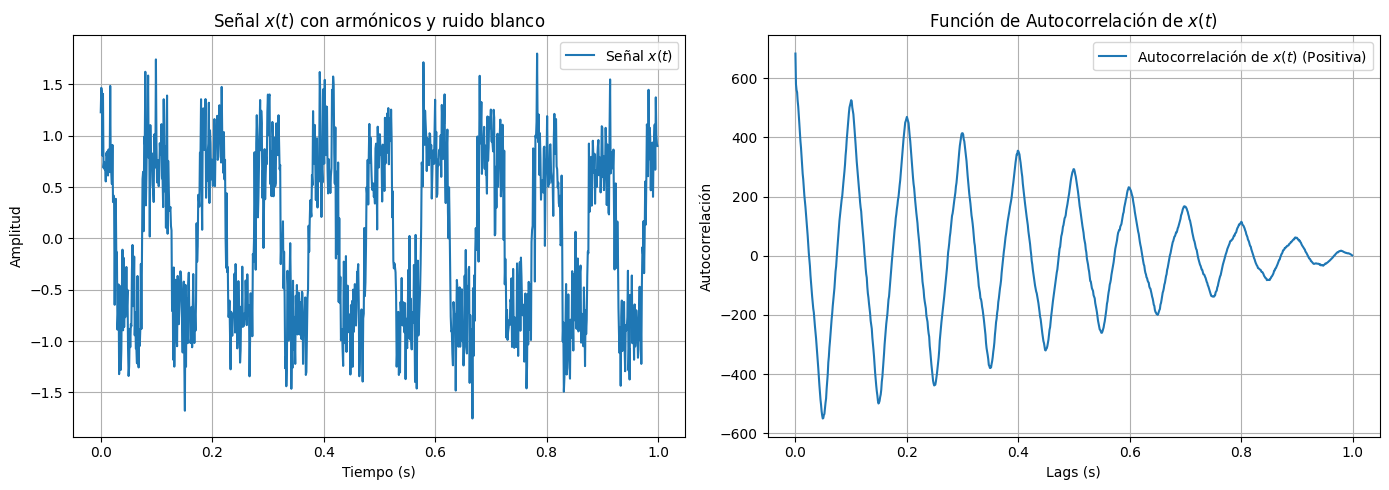

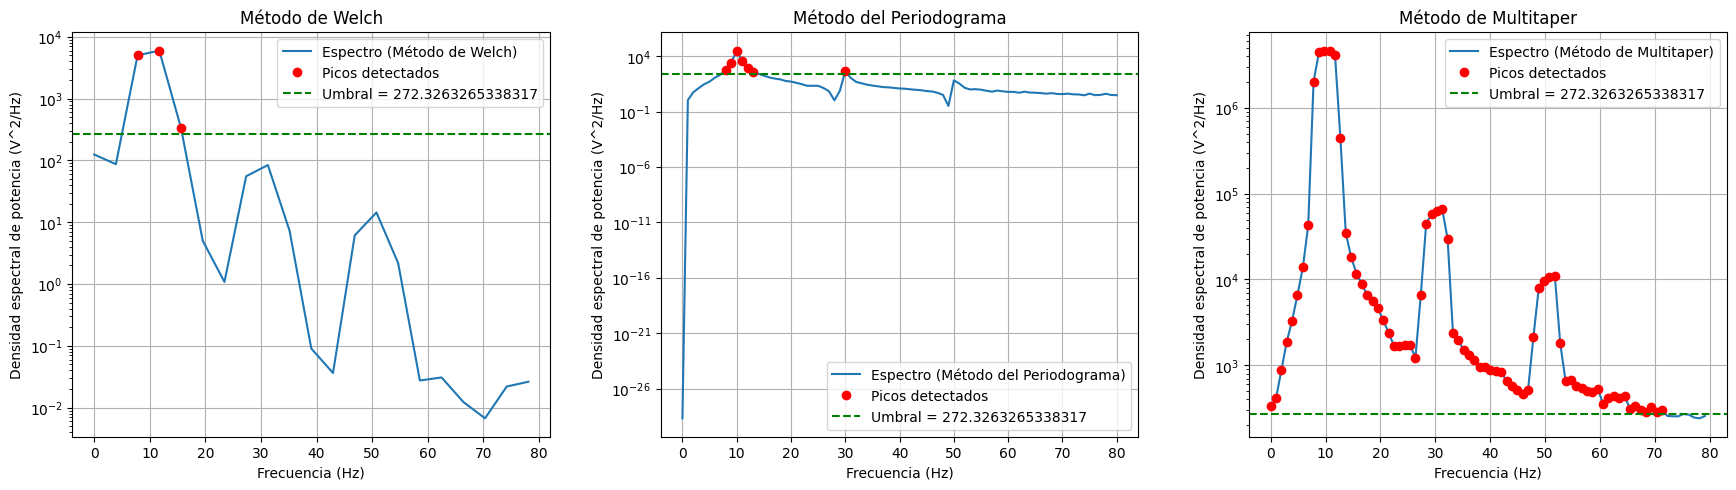

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate, welch, periodogram
from spectrum import pmtm

# Definir funciones

def generar_senal(t, Wo, varianza_ruido=0.1):
    """
    Genera una señal con armónicos y ruido blanco gaussiano.
    """
    x_t = np.cos(Wo * t) - (1/3) * np.cos(3 * Wo * t) + (1/5) * np.cos(5 * Wo * t)
    ruido = np.random.normal(0, np.sqrt(varianza_ruido), len(t))
    x_t += ruido
    return x_t


def calcular_autocorrelacion(x_t):
    """
    Calcula la autocorrelación de la señal x_t y retorna solo la parte positiva.
    """
    autocorr = correlate(x_t, x_t, mode='full')
    return autocorr[len(x_t)-1:]


def estimar_psd_metodos(autocorr_pos, fs):
    """
    Estima la densidad espectral de potencia utilizando los métodos de Welch, Periodograma y Multitaper.
    """
    f_welch, Pxx_welch = welch(autocorr_pos, fs, nperseg=256)
    f_periodogram, Pxx_periodogram = periodogram(autocorr_pos, fs)
    tapers, _, *_ = pmtm(autocorr_pos, NW=2.5, k=4, show=False)
    psd_multitaper = np.mean([np.abs(taper)**2 for taper in tapers], axis=0)
    frecuencias_multitaper = np.fft.fftfreq(len(psd_multitaper), d=1/fs)
    return (f_welch, Pxx_welch), (f_periodogram, Pxx_periodogram), (frecuencias_multitaper, psd_multitaper)


def detectar_picos(psd, frecuencias, umbral):
    """
    Detecta los picos que superan un umbral en un espectro de potencia.
    """
    picos = psd[psd > umbral]
    frecuencias_picos = frecuencias[psd > umbral]
    return frecuencias_picos, picos


def calcular_umbral_ruido(psd_ruido, factor=3):
    """
    Calcula un umbral adaptativo basado en el nivel de ruido.
    """
    media_ruido = np.mean(psd_ruido)
    return factor * media_ruido


def graficar_senal_y_autocorrelacion(t, x_t, lags_pos, autocorr_pos):
    """
    Grafica la señal x(t) y su autocorrelación positiva.
    """
    plt.figure(figsize=(14, 5))

    # Gráfica de la señal x(t)
    plt.subplot(1, 2, 1)
    plt.plot(t, x_t, label="Señal $x(t)$")
    plt.title("Señal $x(t)$ con armónicos y ruido blanco")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.grid()

    # Gráfica de la función de autocorrelación solo para lags positivos
    plt.subplot(1, 2, 2)
    plt.plot(lags_pos / fs, autocorr_pos, label="Autocorrelación de $x(t)$ (Positiva)")
    plt.title("Función de Autocorrelación de $x(t)$")
    plt.xlabel("Lags (s)")
    plt.ylabel("Autocorrelación")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


def graficar_psd_metodos(metodos_psd, umbral):
    """
    Grafica la densidad espectral de potencia utilizando distintos métodos y resalta los picos detectados.
    """
    titulos = ["Método de Welch", "Método del Periodograma", "Método de Multitaper"]
    plt.figure(figsize=(18, 10))

    for i, ((frecuencias, psd), titulo) in enumerate(zip(metodos_psd, titulos)):
        # Detectar picos
        frecuencias_picos, picos = detectar_picos(psd[:len(frecuencias)//2], frecuencias[:len(frecuencias)//2], umbral)

        plt.subplot(2, 3, i + 1)
        plt.semilogy(frecuencias[:len(psd)//2][frecuencias[:len(psd)//2] <= 80], psd[:len(psd)//2][frecuencias[:len(psd)//2] <= 80], label=f"Espectro ({titulo})")
        plt.semilogy(frecuencias_picos[frecuencias_picos <= 80], picos[frecuencias_picos <= 80], 'ro', label="Picos detectados")
        plt.axhline(umbral, color='g', linestyle='--', label=f"Umbral = {umbral}")  # Línea horizontal
        plt.title(titulo)
        plt.xlabel("Frecuencia (Hz)")
        plt.ylabel("Densidad espectral de potencia (V^2/Hz)")
        plt.legend()
        plt.grid()

    plt.tight_layout(pad=3.0)
    plt.show()

# Parámetros generales
fs = 1000  # Frecuencia de muestreo en Hz
T = 1      # Duración de la señal en segundos
t = np.linspace(0, T, int(fs * T), endpoint=False)

# Frecuencia angular fundamental
Wo = 2 * np.pi * 10  # Frecuencia fundamental en radianes por segundo

# Generar la señal x(t)
x_t = generar_senal(t, Wo)

# Calcular la autocorrelación de x(t)
autocorr_pos = calcular_autocorrelacion(x_t)
lags_pos = np.arange(0, len(autocorr_pos))

# Graficar la señal y su autocorrelación
graficar_senal_y_autocorrelacion(t, x_t, lags_pos, autocorr_pos)

# Estimar la PSD usando diferentes métodos
metodos_psd = estimar_psd_metodos(autocorr_pos, fs)

# Calcular umbral basado en el ruido o utilizar un valor proporcionado
umbral = calcular_umbral_ruido(metodos_psd[0][1]) if 'umbral_usuario' not in globals() else umbral_usuario

# Graficar las PSD y los picos detectados
graficar_psd_metodos(metodos_psd, umbral)
